<a href="https://colab.research.google.com/github/hida0/ESAA/blob/HW/Week5_HW1_sklearn_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 개념정리 & 필사
## [사이킷런으로 수행하는 타이타닉 생존자 예측]
### 타이타닉 탑승자 데이터
* Passengerid: 탑승자 데이터 일련번호
* survived: 생존 여부, 0=사망, 1=생존
* plcass: 티켓의 선실 등급, 1=일등석, 2=이등석, 3=삼등석
* sex: 탑승자 성별
* name: 탑승자 이름
* Age: 탑승자 나이
* sibsp: 같이 탑승한 형제자매 또는 배우자 인원수
* parch: 같이 탑승한 부모님 또는 어린이 인원수
* ticket: 티켓 번호
* fare: 요금
* cabin: 선실 번호
* embarked: 중간 정착 항구 C=Cherbourg, Q=Queenstown, S=Southampton

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [17]:
titanic_df = pd.read_csv('/content/drive/MyDrive/ESAA/data/titanic_train.csv')
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


### 타이타닉 탑승자 데이터 전처리
#### 1. **info()**를 이용하여 타이타닉 데이터 칼럼 타입을 확인할 수 있다.
* RangeIndex : DataRrame 인덱스의 범위, 즉 전체 로우의 개수로 891개
* Dtype : 칼럼의 타입으로 int형, float형, object(string)형
* Non-Null Count : 각 칼럼에서 Null 값이 아닌 자료의 개수

#### 2. **fillna()**를 이용하여 Null 값을 평균 또는 고정 값으로 변경할 수 있다.
* 변경하기 원하는 값을 fillna()의 인자로 입력한다.
* fillna()의 인자로 **inplace=True**를 입력하여 자료를 변경한 값으로 저장한다.

#### 3. **isnull()**과 **sum()**을 이용하여 Null 값이 없이 전처리가 잘 되었는지 확인한다.

#### 4. 문자열 칼럼의 데이터 분포를 확인하여 올바른 분포를 갖도록 변경한다.
* **value_counts()**를 이용하여 Sex, Cabin, Embarked 칼럼의 데이터 분포를 확인한다. 
* Cabin 칼럼이 적절한 분포를 갖도록 자료 값의 앞문자만 추출하는 전처리를 진행한다

In [3]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [18]:
titanic_df['Age'].fillna(titanic_df['Age'].mean(), inplace=True)
titanic_df['Cabin'].fillna('N', inplace=True)
titanic_df['Embarked'].fillna('N', inplace=True)

titanic_df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [9]:
print("Sex 값 분포:\n", titanic_df['Sex'].value_counts())
print("Cabin 값 분포:\n", titanic_df['Cabin'].value_counts())
print("Embarked 값 분포:\n", titanic_df['Embarked'].value_counts())

Sex 값 분포:
 male      577
female    314
Name: Sex, dtype: int64
Cabin 값 분포:
 N              687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: Cabin, Length: 148, dtype: int64
Embarked 값 분포:
 S    644
C    168
Q     77
N      2
Name: Embarked, dtype: int64


In [19]:
titanic_df['Cabin'] = titanic_df['Cabin'].str[:1] # 자료의 첫번째 값만을 Cabin 칼럼에 다시 저장
titanic_df['Cabin'].value_counts()

N    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64

### 타이타닉 탑승자 데이터 탐색
#### 1. 성별이 생존 확률에 미치는 영향
* **groupby()**를 이용하여 성별에 따른 생존자 수를 비교한다.
* 'Survived'의 0은 사망, 1은 생존을 나타낸다. 여자는 74.2%(314명 중 233명)가 생존했고, 남자는 18.8%(577명 중 109명)가 생존했다.
* **Seaborn의 barplot()**를 통해 **생존 확률**을 막대그래프로 그려 시각화할 수 있다.

#### 2. 객실 등급이 생존 확률에 미치는 영향
* **groupby()**를 이용하여 객실 등급과 성별에 따른 생존자 수를 비교한다.
* **Seaborn의 barplot()**를 통해 **생존 확률**을 막대그래프로 그려 시각화할 수 있다. **hue** 인자에 그래프를 구분할 칼럼을 입력하여 객실 등급과 성별로 구분한다.
* 남자는 일등실의 생존 확률이 이등, 삼등실의 생존 확률보다 높다. 여자는 일등, 이등실의 생존 확률의 차이는 크지 않으나 삼등실의 생존 확률은 상대적으로 많이 떨어진다.

#### 3. 나이가 생존 확률에 미치는 영향
* 'Age' 값의 종류가 많으므로 범위별로 분류하여 카테고리의 값을 할당한다. 0-5세는 Baby, 6-12세는 Child, 13-18세는 Teenager, 19-25세는 Student, 26-35세는 Young Adult, 36-60세는 Adult, 61세 이상은 Elderly로 분류하고 -1 이하의 오류 값은 Unknown으로 분류한다.
* 'Age'에 따라 구분 값을 반환하는 함수를 선언하고, **apply lambda**를 이용하여 적용한다.

In [13]:
titanic_df.groupby(['Sex', 'Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

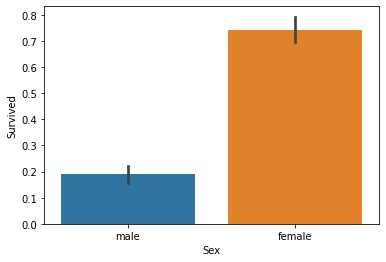

In [14]:
# 성별에 따른 생존 확률
sns.barplot(x='Sex', y='Survived', data=titanic_df)

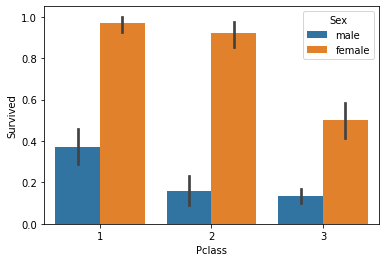

In [15]:
# 객실 등급과 성별에 따른 생존 확률
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=titanic_df)

In [22]:
# 'Age' 값에 따라 구분 값을 반환하는 함수를 선언
def get_category(age):
    cat = ''
    if age <= -1: cat = 'Unknown'
    elif age <= 5: cat = 'Baby'
    elif age <= 12: cat = 'Child'
    elif age <= 18: cat = 'Teenager'
    elif age <= 25: cat = 'Student'
    elif age <= 35: cat = 'Young Adult'
    elif age <= 60: cat = 'Adult'
    else: cat = 'Elderly'
    
    return cat
# 함수를 적용하여 새로운 열을 생성
titanic_df['Age_cat'] = titanic_df['Age'].apply(lambda x: get_category(x))

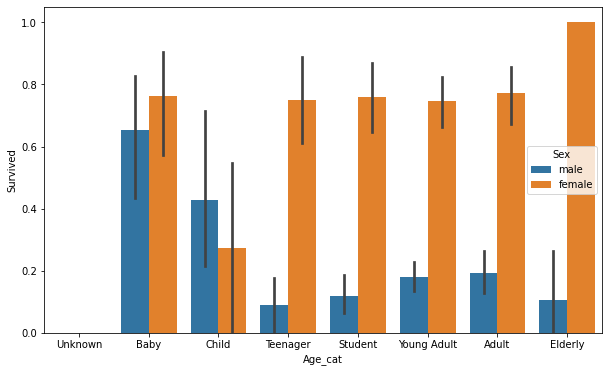

In [24]:
group_names = ['Unknown','Baby','Child','Teenager','Student','Young Adult', 'Adult','Elderly'] # x축의 값을 순차적으로 표현하기 위한 설정
plt.figure(figsize=(10,6))
sns.barplot(x='Age_cat', y='Survived', hue='Sex', data=titanic_df, order=group_names)

### 타이타닉 탑승자 데이터 전처리 (문자열 카테고리 피처 -> 숫자형 카테고리 피처)
* **sklearn의 preprocessing**의 **LabelEncoder** 클래스를 이용하여 레이블 인코딩을 적용한다.
* LabelEncoder 객체는 카테고리 값의 유형 수에 따라 0부터 (카테고리유형수-1)까지의 숫자 값으로 변환한다.
* **fit()**과 **transform()**를 이용하여 데이터를 변환한다.
* 새로 함수를 선언하여 여러 개의 문자열 칼럼을 한번에 변환할 수 있다.

In [25]:
from sklearn import preprocessing

# 여러 칼럼을 한번에 변환하는 함수를 선언
def encode_features(dataDF):
    features = ['Cabin','Sex','Embarked']
    for feature in features:
        le = preprocessing.LabelEncoder() # LabelEncoder 클래스 선언
        le.fit(dataDF[feature])
        dataDF[feature] = le.transform(dataDF[feature])
    return dataDF

titanice_df = encode_features(titanic_df)
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_cat
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,7,3,Student
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0,Adult
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,7,3,Young Adult


### 타이타닉 탑승자 데이터 전처리
* 지금까지 데이터의 피처를 전처리한 내용을 정리하고 이를 하나의 함수로 만들어 쉽게 재사용할 수 있다.
* 데이터 전처리를 전체적으로 호출하는 함수를 transform_features()로 선언하며, Null 처리, 포매팅, 인코딩을 수행하는 내부 함수로 구성한다.

In [26]:
# Null 값을 처리
def fillna(df):
    df['Age'].fillna(titanic_df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 속성을 제거
def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'], axis=1, inplace=True)
    return df

# 레이블 인코딩을 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin','Sex','Embarked']
    for feature in features:
        le = preprocessing.LabelEncoder() # LabelEncoder 클래스 선언
        le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 데이터 전처리 함수를 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [27]:
# 원본 데이터를 다시 로드하여 피처 데이터 세트와 레이블 데이터 세트를 추출
titanic_df = pd.read_csv('/content/drive/MyDrive/ESAA/data/titanic_train.csv')
Y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)

# 데이터 전처리 함수를 적용
X_titanic_df = transform_features(X_titanic_df)

### 타이타닉 탑승자 데이터 생존자 예측
* **sklearn.model_selection**의 **train_test_split()**을 이용하여 데이터를 학습 데이터와 테스트 데이터로 분리한다.
* ML 알고리즘인 결정 트리, 랜덤 포레스트, 로지스틱 회귀를 이용하여 타이타닉 생존자를 에측한다.
* 사이킷런은 결정 트리를 위해 sklearn.tree의 **DecisionTreeClassifier**, 랜덤 포레스트를 위해 sklearn.ensemble의 **RandomForestClassifier**, 로지스틱 회귀를 위해 sklearn.linear_model의 **LogisticRegression** 클래스를 제공한다.
* 예측 성능 평가로 정확도를 판단하기 위해 sklearn.metrics의 **accuracy_score**를 사용한다.

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_titanic_df, Y_titanic_df, test_size=0.2, random_state=11)

In [47]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression()

In [48]:
# 결정 트리 학습/예측/평가
dt_clf.fit(X_train, Y_train)
dt_pred = dt_clf.predict(X_test)
print("DecisionTreeClassifier 정확도: {0:.4f}".format(accuracy_score(Y_test, dt_pred)))

DecisionTreeClassifier 정확도: 0.7877


In [39]:
# 랜덤 포레스트 학습/예측/평가
rf_clf.fit(X_train, Y_train)
rf_pred = rf_clf.predict(X_test)
print("RandonForestClassifier 정확도: {0:.4f}".format(accuracy_score(Y_test, rf_pred)))

RandonForestClassifier 정확도: 0.8547


In [41]:
# 로지스틱 회귀 학습/예측/평가
lr_clf.fit(X_train, Y_train)
lr_pred = lr_clf.predict(X_test)
print("LogisticRegression 정확도: {0:.4f}".format(accuracy_score(Y_test, lr_pred)))

LogisticRegression 정확도: 0.8492


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


### 타이타닉 탑승자 데이터 생존자 예측
* 교차 검증을 통해 결정 트리 모델(dt_clf)을 더 평가한다.
* **sklearn.model_selection**의 **KFold, cross_val_score(), GridSearchCV** 클래스를 이용한다.
* KFold와 cross_val_score()의 평균 정확도가 약간 다른데, 이는 cross_val_score()가 StratifiedKFold를 이용하여 폴드 세트를 분할하기 때문이다.
* GridSearchCV를 이용하여 DecisionTreeClassifier의 최적 하이퍼 파라미터를 찾고 예측 성능을 측정한다. CV는 5개의 폴드 세트로 지정하고 하이퍼 파라미터는 max-depth, min_samples_split, min_samples_leaf를 변경하면서 성능을 측정한다. 최적 하이퍼 파라미터(**best_params_**)와 최고 정확도(**best_score_**)를 출력하고, 최적 하이퍼 파라미터로 학습된 Estimator(**best_estimator_**)를 이용하여 예측을 수행하여 예측 정확도를 출력한다.

In [49]:
# 폴드가 5개인 KFold 교차 검증
from sklearn.model_selection import KFold

def exec_kfold(clf, folds=5):
    kfold = KFold(n_splits=folds) # 폴드 세트가 5개인 KFold 객체를 생성
    scores = [] # 폴드 수만큼 예측 결과를 저장할 비어있는 리스트 객체를 생성

    for iter_count, (train_idx, test_idx) in enumerate(kfold.split(X_titanic_df)):
        # X_titanic_df 에서 교차 검증별로 학습 데이터와 검증 데이터를 가리키는 index를 생성
        X_train, X_test = X_titanic_df.values[train_idx], X_titanic_df.values[test_idx]
        Y_train, Y_test = Y_titanic_df.values[train_idx], Y_titanic_df.values[test_idx]
        # Classifier 학습, 예측, 정확도를 계산
        clf.fit(X_train, Y_train)
        preds = clf.predict(X_test)
        accuracy = accuracy_score(Y_test, preds)
        scores.append(accuracy) # 계산한 정확도를 scores에 추가
        print("교차 검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))
    
    # 5개 폴드의 평균 정확도 계산
    mean_score = np.mean(scores)
    print("평균 정확도: {0:.4f}".format(mean_score))

exec_kfold(dt_clf, folds=5)

교차 검증 0 정확도: 0.7542
교차 검증 1 정확도: 0.7809
교차 검증 2 정확도: 0.7865
교차 검증 3 정확도: 0.7697
교차 검증 4 정확도: 0.8202
평균 정확도: 0.7823


In [50]:
# cross_val_score()을 이용한 교차 검증
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dt_clf, X_titanic_df, Y_titanic_df, cv=5)

for iter_count, accuracy in enumerate(scores):
    print("교차 검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))

print("평균 정확도: {0:.4f}".format(np.mean(scores)))

교차 검증 0 정확도: 0.7430
교차 검증 1 정확도: 0.7753
교차 검증 2 정확도: 0.7921
교차 검증 3 정확도: 0.7865
교차 검증 4 정확도: 0.8427
평균 정확도: 0.7879


In [52]:
# GridSearchCV를 이용하여 최적의 파라미터 찾기
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[2,3,5,10], 'min_samples_leaf':[1,5,8], 'min_samples_split':[2,3,5]}

grid_dclf = GridSearchCV(dt_clf, param_grid=parameters, scoring='accuracy', cv=5)
grid_dclf.fit(X_train, Y_train)

print("GridSearchCV 최적 하이퍼 파라미터: ", grid_dclf.best_params_)
print("GridSearchCV 최고 정확도: {0:.4f}".format(grid_dclf.best_score_))

# 최적 하이퍼 파라미터로 모델을 학습
best_dclf = grid_dclf.best_estimator_

# train과 test로 분리된 테스트 데이터를 최적 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가 수행
dpred = best_dclf.predict(X_test)
accuracy = accuracy_score(Y_test, dpred)
print("테스트 세트에서의 DecisionTreeClassifier 정확도: {0:.4f}".format(accuracy))

GridSearchCV 최적 하이퍼 파라미터:  {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
GridSearchCV 최고 정확도: 0.7992
테스트 세트에서의 DecisionTreeClassifier 정확도: 0.8715
